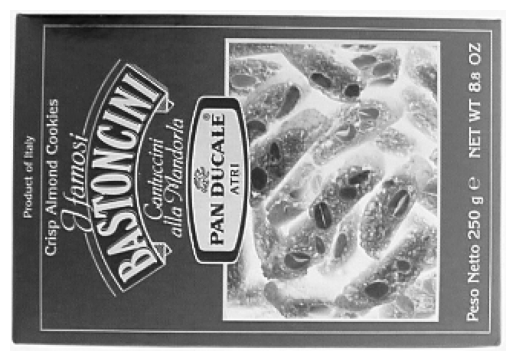

In [29]:
import pickle
from typing import Union

from PIL import Image
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.pyplot import figure, imshow
import numpy as np
import numpy.typing as npt


def get_image(filename: str) -> np.array:
    dir = "images/"
    image = Image.open(dir + filename)
    image_array = np.array(image)
    return image_array


def show_image(array: np.array, mode: Union[str, None] = 'Greys'):
    figure()
    plt.axis('off')
    imshow(array, cmap=mode)


show_image(get_image('box.png'))

In [30]:
def scale(img: npt.NDArray[int], multiplier: int):
    h, w = img.shape
    h //= multiplier
    w //= multiplier

    result_image = np.zeros((h, w), dtype=int)

    for i in range(0, h):
        for j in range(0, w):
            result_image[i, j] = int(np.mean(img[i * multiplier:(i + 1) * multiplier, j * multiplier:(j + 1) * multiplier]))

    return result_image

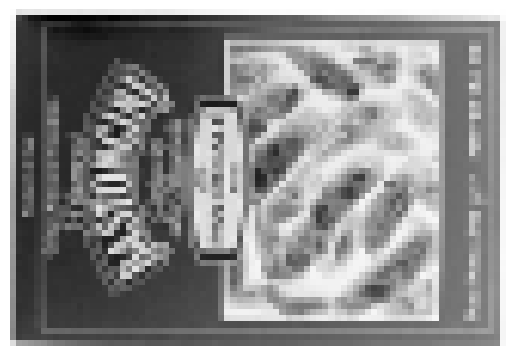

In [31]:
box = get_image("box.png")
test_image = get_image("box_in_scene.png")
box_x2 = scale(box, 2)
box_x4 = scale(box_x2, 2)
show_image(box_x4)

In [32]:
def get_gaussian(size: int, sigma: float = .84089642) -> npt.NDArray[float]:
    pad = size // 2

    K = np.zeros((size, size), np.float64)
    for x in range(-pad, -pad + size):
        for y in range(-pad, -pad + size):
            K[x + pad, y + pad] = np.exp( -(x * x + y * y) / (2 * (sigma * sigma)))
    K /= 2 * np.pi * sigma * sigma
    K /= K.sum()
    return K

In [33]:
def extend_image(img, size: int) -> npt.NDArray[npt.NDArray[int]]:
    h, w = img.shape
    out = np.zeros((h + size * 2, w + size * 2), dtype=img.dtype)
    out[size:size + h, size: size + w] = img
    for i in range(size):
        out[size:size + h, i] = img[:, 0]
        out[size:size + h, size + w + i] = img[:, w - 1]
    for i in range(size):
        out[size - i - 1, :] = out[size, :]
        out[size + h + i, :] = out[size + h - 1, :]
    return out

In [34]:
def get_list_circle_bresenham(area: npt.NDArray[npt.NDArray[int]], r: int = 3) -> tuple[int]:
    return (area[0, 3], area[0, 4], area[1, 5], area[2, 6], area[3, 6], area[4, 6], area[5, 5],
            area[6, 4], area[6, 3], area[6, 2], area[5, 1], area[4, 0], area[3, 0], area[2, 0],
            area[1, 1], area[0, 2])

In [35]:
def is_special(points: tuple[int], p: int, t: int) -> bool:
    greater = points[0] > p + t, points[4] > p + t, points[8] > p + t, points[12] > p + t
    less = points[0] < p + t, points[4] < p + t, points[8] < p + t, points[12] < p + t
    if sum(greater) < 3 and sum(less) < 3:
        return False

    gt = lt = False
    cnt = 0
    for i in range(len(points)):
        if points[i] < p + t:
            if gt:
                gt = False
            if not lt:
                lt = True
                cnt = 0
            cnt += 1
        elif points[i] > p + t:
            if lt:
                lt = False
            if not gt:
                gt = True
                cnt = 0
            cnt += 1
        else:
            cnt = 0
        if cnt == 12:
            return True
        if len(points) - i - 1 + cnt < 12:
            return False
    return False

In [36]:
def fast(img, r: int, t: int) -> npt.NDArray[bool]:
    extended_image = extend_image(img, r)
    h, w = img.shape
    marks = np.zeros((h, w), dtype=bool)
    for i in range(h):
        for j in range(w):
            i_end = i + r * 2 + 1
            if i_end == extended_image.shape[0]:
                i_end = None
            j_end = j + r * 2 + 1
            if j_end == extended_image.shape[1]:
                j_end = None
            points = get_list_circle_bresenham(extended_image[i: i_end, j: j_end])
            if is_special(points, img[i, j], t):
                marks[i, j] = True
    return marks

In [37]:
def filter_sobel(image) -> npt.NDArray[list[tuple[int, int]]]:
    H, W = image.shape

    out = np.zeros((H + 2, W + 2, 2), np.float64)
    out[1: 1 + H, 1: 1 + W, 0] = image.copy().astype(np.float64)
    out[0, 0, 0] = out[1, 1, 0]
    out[-1, 0, 0] = out[-2, 1, 0]
    out[0, -1, 0] = out[1, -2, 0]
    out[-1, -1, 0] = out[-2, -2, 0]
    out[1: 1 + H, 0, 0] = out[1: 1 + H, 1, 0]
    out[1: 1 + H, -1, 0] = out[1: 1 + H, -2, 0]
    out[0, 1: 1 + W, 0] = out[1, 1: 1 + W, 0]
    out[-1, 1: 1 + W, 0] = out[-2, 1: 1 + W, 0]

    Mx = np.array([
        [-1, 0, 1],
        [-2, 0, 2],
        [-1, 0, 1]],
        dtype=int
    )
    My = np.array([
        [-1, -2, -1],
        [0, 0, 0],
        [1, 2, 1]
    ],
        dtype=int
    )
    tmp = out.copy()

    # Ix, Iy
    for y in range(H):
        for x in range(W):
            out[1 + y, 1 + x] = (np.sum(Mx * tmp[y: y + 3, x: x + 3, 0]), np.sum(My * tmp[y: y + 3, x: x + 3, 0]))
    return out[1: 1 + H, 1: 1 + W]

In [38]:
def harris(img: npt.NDArray[int], candidates: npt.NDArray[bool], k: float = 0.05) -> npt.NDArray[float]:
    gaussian = get_gaussian(5)
    size = 2
    extended_img = extend_image(img, size)
    gradients = filter_sobel(extended_img)
    result = np.zeros(img.shape, dtype=float)
    Ix = gradients[:, :, 0]
    Iy = gradients[:, :, 1]
    candidates_coords = np.argwhere(candidates)

    for i, j in candidates_coords:
        i_end = i + size * 2 + 1
        if i_end >= extended_img.shape[0]:
            i_end = None
        j_end = j + size * 2 + 1
        if j_end >= extended_img.shape[1]:
            j_end = None
        Wxx = Ix[i:i_end, j:j_end] ** 2 * gaussian
        Wxy = Ix[i:i_end, j:j_end] * Iy[i:i_end, j:j_end] * gaussian
        Wyy = Iy[i:i_end, j:j_end] ** 2 * gaussian
        M = np.array([
            [np.sum(Wxx), np.sum(Wxy)],
            [np.sum(Wxy), np.sum(Wyy)]
        ], dtype=float)
        R = np.linalg.det(M) - k * np.matrix.trace(M) ** 2
        result[i, j] = R

    return result

In [39]:
def non_maximum_suppression(harris_values: npt.NDArray[float], offset: float = 0.01):
    max_point = np.max(harris_values)
    special_points = harris_values > offset * max_point
    harris_values[~special_points] = 0
    return np.argwhere(harris_values)

In [40]:
fast_box = fast(box, 3, 30)
fast_box_x2 = fast(box_x2, 3, 30)
fast_box_x4 = fast(box_x4, 3, 30)
fast_test = fast(test_image, 3, 30)

In [71]:
len(fast_box[0])

324

In [41]:
points_box = harris(box, fast_box, 0.04)
points_box_x2 = harris(box_x2, fast_box_x2, 0.04)
points_box_x4 = harris(box_x4, fast_box_x4, 0.04)
points_test = harris(test_image, fast_test, 0.04)

In [42]:
points_box = non_maximum_suppression(points_box, 0.125)
points_box_x2 = non_maximum_suppression(points_box_x2, 0.125)
points_box_x4 = non_maximum_suppression(points_box_x4, 0.125)
points_test = non_maximum_suppression(points_test, 0.125)

In [43]:
def get_image_with_points(img: npt.NDArray[int], points: npt.NDArray[int]) -> npt.NDArray[int]:
    h, w = img.shape
    result_image = np.zeros((h, w, 3), dtype=int)
    result_image[:, :, 0] = img[:, :]
    result_image[:, :, 1] = img[:, :]
    result_image[:, :, 2] = img[:, :]

    point_color = (255, 0, 0)
    figure()
    for p in points:
        i, j = p
        result_image[i - 1:i + 1, j - 1:j + 1] = point_color

    return result_image

<Figure size 640x480 with 0 Axes>

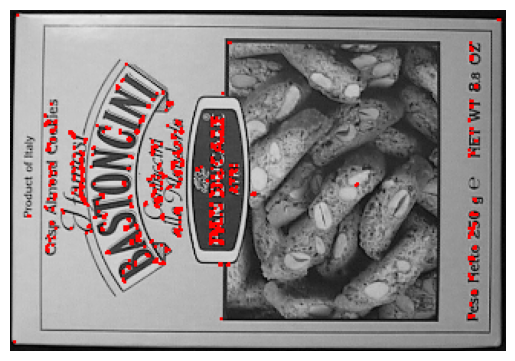

In [44]:
show_image(get_image_with_points(box, points_box))

<Figure size 640x480 with 0 Axes>

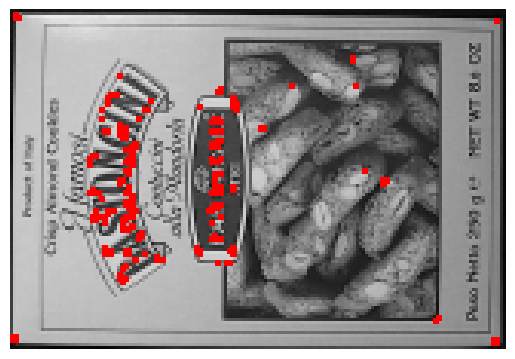

In [45]:
show_image(get_image_with_points(box_x2, points_box_x2))

<Figure size 640x480 with 0 Axes>

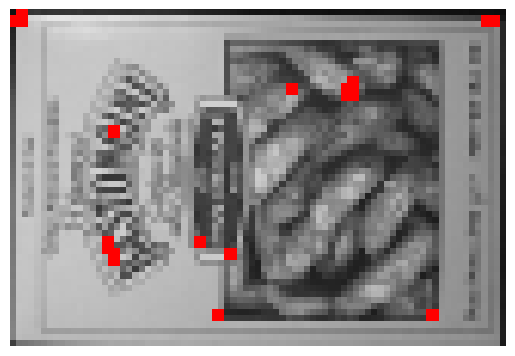

In [46]:
show_image(get_image_with_points(box_x4, points_box_x4))

<Figure size 640x480 with 0 Axes>

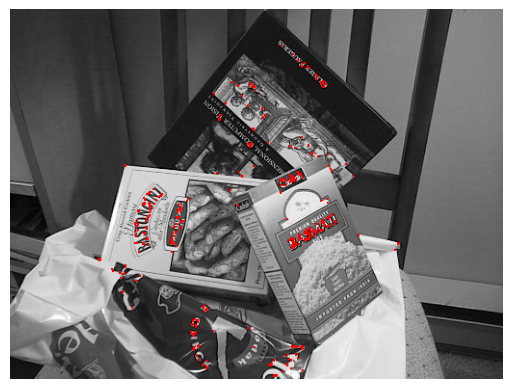

In [47]:
show_image(get_image_with_points(test_image, points_test))

In [48]:
def calculate_orientation(points: npt.NDArray[int], img: npt.NDArray[int]) -> list[float]:
    size = 31
    extended_image = extend_image(img, size // 2)
    orientations = []
    h, w = extended_image.shape
    for i, j in points:
        i_end = i + size
        if i_end >= h:
            i_end = None
        j_end = j + size
        if j_end >= w:
            j_end = None
        window = extended_image[i:i_end, j:j_end]
        window_coords = np.argwhere(window >= 0).reshape((size, size, 2))
        window_coords -= size // 2
        m01 = np.sum(window_coords[:, :, 0] * window)
        m10 = np.sum(window_coords[:, :, 1] * window)
        theta = np.arctan2(m01, m10)
        orientations.append(theta % (2 * np.pi))

    return orientations

In [49]:
orientation_box = calculate_orientation(points_box, box)
orientation_box_x2 = calculate_orientation(points_box_x2, box_x2)
orientation_box_x4 = calculate_orientation(points_box_x4, box_x4)
orientation_test = calculate_orientation(points_test, test_image)

In [50]:
def image_filter(K_size, sigma, im):
    H, W = im.shape

    pad = K_size // 2
    out = np.zeros((H + pad * 2, W + pad * 2), np.float64)
    out[pad: pad + H, pad: pad + W] = im.copy().astype(np.float64)

    K = np.zeros((K_size, K_size), np.float64)
    for x in range(-pad, -pad + K_size):
        for y in range(-pad, -pad + K_size):
            K[x + pad, y + pad] = np.exp( -(x * x + y * y) / (2 * (sigma * sigma)))
    K /= 2 * np.pi * sigma * sigma
    K /= K.sum()

    tmp = out.copy()

    for y in range(H):
        for x in range(W):
            out[pad + y, pad + x] = np.sum(K * tmp[y: y + K_size, x: x + K_size])
    out = np.clip(out, 0, 255).astype(int)
    return out[pad: pad + H, pad: pad + W]

In [51]:
blurred_box = image_filter(3, 1.2, box)
blurred_box_x2 = image_filter(3, 1.2, box_x2)
blurred_box_x4= image_filter(3, 1.2, box_x4)
blurred_test = image_filter(3, 1.2, test_image)

In [52]:
def get_descriptor_angle(point_angle: float) -> float:
    imin = 0
    min_diff = 3 * np.pi
    for i, angle in enumerate(np.linspace(0, 2 * np.pi, 30, endpoint=False)):
        abs_diff = abs(angle - point_angle)
        if abs_diff < min_diff:
            imin = i
            min_diff = abs_diff
    return 2 * np.pi / 30 * imin

In [56]:
def special_points_descriptor(image: npt.NDArray[int], orientations: list[int], points: npt.NDArray[int]) -> npt.NDArray[int]:
    size = 31
    pair_count = 256
    extended_image = extend_image(image, size // 2)
    # MRot = Rotation.from_euler('z', [np.pi/2]).as_matrix()
    descriptor = []
    h, w = extended_image.shape
    for o, (i, j) in zip(orientations, points):
        i_end = i + size
        if i_end >= h:
            i_end = None
        j_end = j + size
        if j_end >= w:
            j_end = None
        angle = get_descriptor_angle(o)
        MRot = np.array([[np.cos(angle), -np.sin(angle)],
                         [np.sin(angle), np.cos(angle)]])
        window = extended_image[i:i_end, j:j_end]
        # window_coords = np.argwhere(window >= 0)
        # np.random.shuffle(window_coords)
        # random_coords = window_coords[:pair_count * 2]
        first_pair = []
        second_pair = []
        for pair_index in range(0, pair_count * 2, 2):
            y, x = int(np.random.normal(size // 2, size // 2 * size // 2 / 100)), int(np.random.normal(size // 2, size // 2 * size // 2 / 110))
            first_rotated_point = (MRot @ (y, x)).astype(int)
            y, x = int(np.random.normal(size // 2, size // 2 * size // 2 / 100)), int(np.random.normal(size // 2, size // 2 * size // 2 / 110))
            # first_rotated_point = (MRot @ random_coords[pair_index]).astype(int)
            # second_rotated_point = (MRot @ random_coords[pair_index + 1]).astype(int)
            second_rotated_point = (MRot @ (y, x)).astype(int)
            first_pair.append(first_rotated_point)
            second_pair.append(second_rotated_point)
        result = []
        for x, y in zip(first_pair, second_pair):
            if window[x[0], x[1]] < window[y[0], y[1]]:
                result.append(1)
            else:
                result.append(0)
        descriptor.append(np.array(result[::-1]))

    return np.array(descriptor)

In [57]:
desc_box = special_points_descriptor(blurred_box, orientation_box, points_box)
desc_box_x2 = special_points_descriptor(blurred_box_x2, orientation_box_x2, points_box_x2)
desc_box_x4 = special_points_descriptor(blurred_box_x4, orientation_box_x4, points_box_x4)
desc_test = special_points_descriptor(blurred_test, orientation_test, points_test)

In [60]:
def compare_descriptors(d1, d2):
  w = len(d1)
  h = len(d2)
  h_dist = np.zeros((w, h), dtype=int)

  for i in range(w):
    for j in range(h):
      v1 = d1[i]
      v2 = d2[j]
      d = sum(np.absolute(v1-v2))
      h_dist[i, j] = d

  return h_dist

In [63]:
def Lowe_test(points1, points2, h_dist):
  R_Lowe = 0.8
  w = h_dist.shape[0]
  h = h_dist.shape[1]

  Lowe_dist1 = []
  Lowe_dist2 = []

  for i in range(w):
    sorted_dist = sorted(h_dist[i])
    for t in range(len(sorted_dist)-1):
      dist1, dist2 = sorted_dist[t:t+2]
      R = dist1/dist2
      if R < R_Lowe:
        j = list(h_dist[i]).index(dist1)
        Lowe_dist1.append([points1[i], points2[j]])
        break

  for i in range(h):
    sorted_dist = sorted(h_dist[:, i])
    # j = list(h_dist[:, i]).index(sorted_dist[0])
    # Lowe_dist2.append([points1[j], points2[i]])
    for t in range(len(sorted_dist)-1):
      dist1, dist2 = sorted_dist[t:t+2]
      R = dist1/dist2
      if R < R_Lowe:
        j = list(h_dist[:, i]).index(dist1)
        Lowe_dist2.append([points1[j], points2[i]])
        break

  return [Lowe_dist1, Lowe_dist2]

In [61]:
h_dist_1_2 = compare_descriptors(desc_box, desc_test)

In [64]:
L_dist_1_2 = Lowe_test(points_box, points_test, h_dist_1_2)
print(len(L_dist_1_2[0]), len(L_dist_1_2[1]))
print(L_dist_1_2)

0 0
[[], []]


In [ ]:
def get_image_with_points(img: npt.NDArray[int], points: tuple[tuple[int, int]]) -> npt.NDArray[int]:
    h, w = img.shape
    result_image = np.zeros((h, w, 3), dtype=int)
    result_image[:, :, 0] = img[:, :]
    result_image[:, :, 1] = img[:, :]
    result_image[:, :, 2] = img[:, :]

    point_color = (255, 0, 0)
    for i, j in points:
        result_image[i - 2:i + 2, j - 2:j + 2] = point_color
    return result_image

In [ ]:
def h_dist(desc_query: str, desc_test: str) -> int:
    return sum((q != t for q, t in zip(desc_query, desc_test)))

In [ ]:
def get_h_dist_matrix(d1: tuple[str], d2: tuple[str]):
    h, w = len(d1), len(d2)
    matrix = np.zeros((h, w), dtype=int)

    for i in range(h):
        for j in range(w):
            matrix[i, j] = h_dist(d1[i], d2[j])

    return matrix

In [ ]:
def Lowe_test(points1: npt.NDArray[int], points2: npt.NDArray[int], h_mat: npt.NDArray[int]) -> dict[tuple[int, int], tuple[int, int]]:
    h, w = len(points1), len(points2)
    R_Lowe = 0.91
    candidates = {}
    for i in range(h):
        h_dist_row = sorted(h_mat[i])
        for index in range(len(h_dist_row) - 1):
            min1, min2 = h_dist_row[index], h_dist_row[index + 1]


        # min1 = min2 = 256
        # min1_point = min2_point = None
        # for test_point in d2:
        #     current_dist = h_dist(d1[query_point], d2[test_point])
        #     if current_dist < min1:
        #         min1, min2 = min2, min1
        #         min1_point, min2_point = min2_point, min1_point
        #         min1 = current_dist
        #         min1_point = test_point
        #         continue
        #     if current_dist < min2:
        #         min2 = current_dist
        #         min2_point = test_point
            if min1 / min2 < R_Lowe:
                min_index = np.where(h_mat[i] == min1)[0][0]
                candidates[tuple(points1[i])] = points2[min_index]
                break

    return candidates

In [ ]:
def cross_check(d1: dict, d2: dict) -> dict[tuple[int, int], tuple[int, int]]:
    result = {}
    for query_point in d1:
        test_point = tuple(d1[query_point])
        if test_point in d2 and tuple(d2[test_point]) == query_point:
            result[query_point] = test_point
    return result
    # candidates = {}
    # detected_points = set()
    # for query_point in query_descriptor:
    #     min_dist = 256
    #     min_point = None
    #     for test_point in test_descriptor:
    #         current_dist = h_dist(query_descriptor[query_point], test_descriptor[test_point])
    #         if current_dist < min_dist and test_point not in detected_points:
    #             min_dist = current_dist
    #             min_point = test_point
    #
    #     candidates[query_point] = min_point
    #     detected_points.add(min_point)
    #
    # return candidates